# IMPORTS

In [1]:
import os
import cv2
import time
import torch
import torch.nn as nn
import torchvision
import pickle
import collections
import random

from tqdm import tqdm
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# TRAVAIL SUR GPU

In [2]:
device = torch.device('cpu')
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    device = torch.device('cuda')

# CRÉATION DES CNN

### AlexNet

In [3]:

class AlexNet(nn.Module):
    def __init__(self, num_classes=4):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(6400, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

### LeNet

In [4]:
class LeNet(nn.Module):
    def __init__(self, num_classes=4):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)  # Update the input size of fc1
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = nn.functional.max_pool2d(nn.functional.relu(self.conv1(x)), (2, 2))
        x = nn.functional.max_pool2d(nn.functional.relu(self.conv2(x)), (2, 2))
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### ResNet

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block = ResidualBlock, layers = [3, 4, 6, 3], num_classes = 4):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Transfer learning with resnet

In [6]:
class ResNetTL(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNetTL, self).__init__()
        self.resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
        for param in self.resnet.parameters():
            param.requires_grad = False
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        x = nn.functional.softmax(x, dim=1)
        return x

In [7]:
class DenseNetTL(nn.Module):
    def __init__(self, num_classes=4):
        super(DenseNetTL, self).__init__()
        self.densenet = torchvision.models.densenet161(weights=torchvision.models.DenseNet161_Weights.DEFAULT)
        for param in self.densenet.parameters():
            param.requires_grad = False
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.densenet(x)
        x = nn.functional.softmax(x, dim=1)
        return x

# TRANSFORMATION POUR AUGMENTATION DES DONNÉES

In [8]:
def transformation_de_base(image):
    # transformation = transforms.Compose([transforms.ToTensor(),transforms.Resize((224, 224))])
    image = transforms.ToTensor()(image)
    image = transforms.Resize((224, 224))(image)
    return image

# Rotation aléatoire
def random_rotation(image):
    angle = torch.rand(1) * 360  # Angle de rotation aléatoire entre 0 et 360 degrés
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(angle.item()),
        transforms.ToTensor(),
        transforms.Resize((224, 224))
    ])
    return transform(image)

def random_translation(image):
    translate_x = torch.rand(1)  # Décalage aléatoire en X entre -1 et 1
    translate_y = torch.rand(1)  # Décalage aléatoire en Y entre -1 et 1

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomAffine(0, translate=(translate_x.item(), translate_y.item())),
        transforms.ToTensor(),
        transforms.Resize((224, 224))
    ])
    return transform(image)

def random_zoom(image):
    scale = (torch.rand(1) + 0.5).item()  # Facteur d'échelle aléatoire entre 0.5 et 1.5
    height, width = image.shape[0], image.shape[1]
    new_height = int(height * scale)
    new_width = int(width * scale)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((new_height, new_width)),
        transforms.CenterCrop((height, width)),
        transforms.ToTensor(),
        transforms.Resize((224, 224))
    ])
    return transform(image)

# Miroir horizontal
def horizontal_flip(image):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Resize((224, 224))
    ])
    return transform(image)

# Miroir vertical
def vertical_flip(image):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomVerticalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Resize((224, 224))
    ])
    return transform(image)

# Changement de luminosité et de contraste
def random_brightness_contrast(image):
    brightness_factor = torch.rand(1) + 0.5  # Facteur de luminosité aléatoire entre 0.5 et 1.5
    contrast_factor = torch.rand(1) + 0.5  # Facteur de contraste aléatoire entre 0.5 et 1.5
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(brightness=brightness_factor.item(), contrast=contrast_factor.item()),
        transforms.ToTensor(),
        transforms.Resize((224, 224))
    ])
    return transform(image)

# Bruit aléatoire
def add_random_noise(image):
    image = transforms.ToTensor()(image)
    image = transforms.Resize((224, 224))(image)
    noise = torch.randn_like(image)  # Bruit aléatoire de la même taille que l'image
    noisy_image = image + noise
    return noisy_image

# Conversion en niveaux de gris
def convert_to_grayscale(image):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Resize((224, 224))
    ])
    return transform(image)

# Découpage aléatoire
def random_crop(image):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomCrop((80, 80)),  # Taille du découpage aléatoire
        transforms.ToTensor(),
        transforms.Resize((224, 224))
    ])
    return transform(image)


# CRÉATION DES JEUX DE DONNÉES

## RÉCUPÉRATION DES IMAGES

In [9]:
def recuperer_image(chemin:str, transform) :
    img = cv2.imread(chemin)                    # taille variable
    return transform(img)

## CRÉATION DES DATAFRAMES

In [10]:
def recuperer_data_train(transform_list) :
    print("recuperer_data_train")
    t0 = time.time()
    current_path = os.getcwd()
    data_read = pd.read_csv(current_path + "/train.csv")

    data_train = pd.DataFrame(columns=["label", "image"])

    for transform in transform_list :
        augmented_data = pd.DataFrame(columns=["label", "image"])
        augmented_data["label"] = (data_read["label"]-1).astype("category")
        augmented_data["image"] = data_read["id"].apply(lambda nom : recuperer_image("train/"+str(nom)+".jpg", transform=transform))
        data_train = pd.concat([data_train, augmented_data], ignore_index=True)
        
    print(data_train.info())
    print("fin recuperer_data_train en", time.time()-t0, "s")
    return data_train

def recuperer_images_test() :
    return [{"image" : recuperer_image("test/"+str(fichier)+".jpg", transformation_de_base)} for fichier in range(4000, 5082)]

/home/florian/miniconda3/envs/tensorflow/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


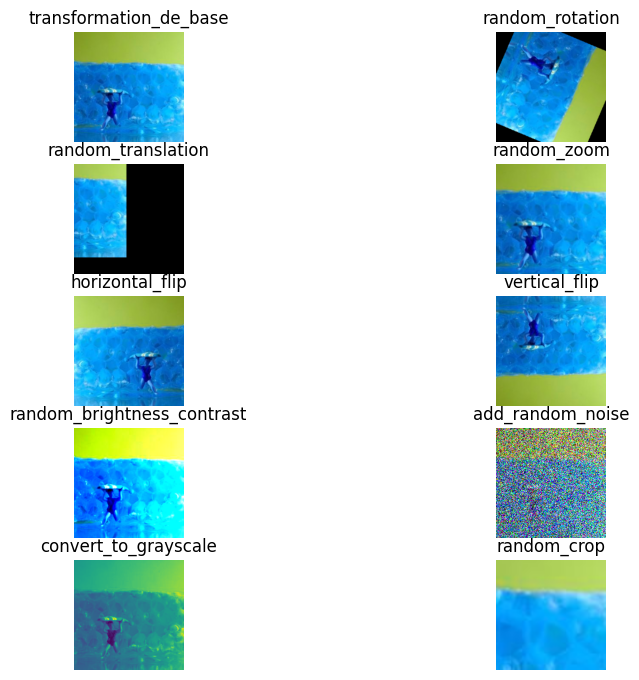

In [11]:
torch.cuda.empty_cache()
transform_list_test = [transformation_de_base, random_rotation, random_translation, random_zoom, horizontal_flip, vertical_flip, random_brightness_contrast, add_random_noise, convert_to_grayscale, random_crop]
transform_list_test_string = ["transformation_de_base", "random_rotation", "random_translation", "random_zoom", "horizontal_flip", "vertical_flip", "random_brightness_contrast", "add_random_noise", "convert_to_grayscale", "random_crop"]
images = []
for t in transform_list_test :
    images.append(recuperer_image("train/0.jpg", t))

nb_transformation = len(transform_list_test)
plt.figure(figsize=(10, 10))
for i in range(nb_transformation) :
    plt.subplot(nb_transformation//2+1, 2, i+1)
    plt.imshow(np.clip(images[i].numpy().transpose(1, 2, 0), 0, 1))
    plt.axis("off")
    plt.title(transform_list_test_string[i])

plt.show()

In [12]:
torch.cuda.empty_cache()
transform_list_all = [random_rotation, random_translation, random_zoom, horizontal_flip, vertical_flip, random_brightness_contrast, add_random_noise, convert_to_grayscale, random_crop]
transform_list = random.sample(transform_list_all, 3) 
transform_list = [transformation_de_base] # transform_list = [transformation_de_base] + transform_list
transform_list = [transformation_de_base, random_zoom, horizontal_flip, vertical_flip]
transform_list_string = ["transformation_de_base", "random_zoom", "horizontal_flip", "vertical_flip"]
data_train = recuperer_data_train(transform_list)

recuperer_data_train


/home/florian/miniconda3/envs/tensorflow/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


/home/florian/miniconda3/envs/tensorflow/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/florian/miniconda3/envs/tensorflow/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   label   16000 non-null  category
 1   image   16000 non-null  object  
dtypes: category(1), object(1)
memory usage: 140.9+ KB
None
fin recuperer_data_train en 42.558085203170776 s


In [13]:
data_test = recuperer_images_test()

/home/florian/miniconda3/envs/tensorflow/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


# AFFICHAGE RÉPARTITION DES CLASSES

In [14]:
def afficher_repartition(data:pd.DataFrame) :
    plt.figure()
    print("affichage répartition par classe")
    x = data["label"].to_list()
    frequence = collections.Counter(x)
    print(dict(frequence))
    plt.hist(x, range=(-0.5, 3.5), bins=4, color="yellow", edgecolor="black")
    plt.xlabel("Label")
    plt.ylabel("Nombre")
    plt.title("Nombre d'image par label")


affichage répartition par classe
{3: 4124, 0: 4028, 2: 3896, 1: 3952}


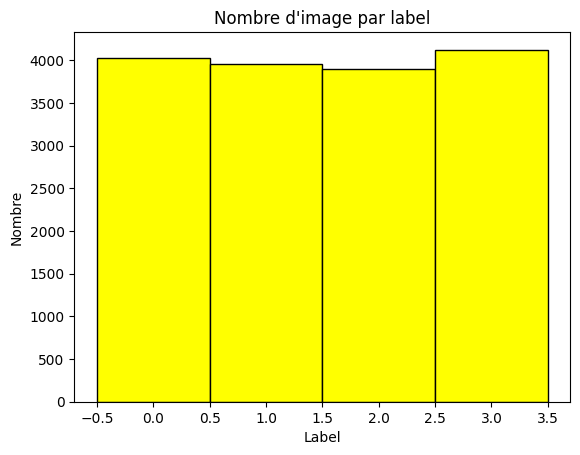

In [15]:
afficher_repartition(data_train)

# AFFICHAGE DES TRANSFORMATIONS SUR LA PREMIÈRE IMAGE

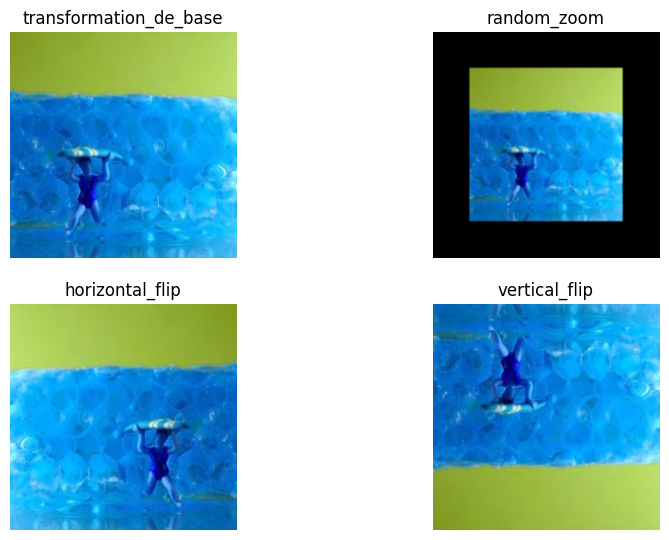

In [16]:
nb_transformation = len(data_train) // 4000
plt.figure(figsize=(10, 10))
for i in range(nb_transformation) :
    plt.subplot(nb_transformation//2 +1, 2, i+1)
    plt.imshow(data_train.loc[i*4000, "image"].numpy().transpose(1, 2, 0))
    plt.axis("off")
    plt.title(transform_list_string[i])
plt.show()

# ENTRAINEMENT DU MODELE

## Fonction de validation

In [17]:
def validation(model, X_load_val, loss=torch.nn.CrossEntropyLoss()) :
    nb_val = len(X_load_val)
    with torch.no_grad() :
        val_losses = []
        predictions_val = 0
        model.eval()
        for _, data in enumerate(tqdm(X_load_val)) :
            X_data, y_data = data["image"].to(device), data["label"].to(device)
            sortie = model(X_data)
            loss_val = loss(sortie, y_data)
            val_losses.append(loss_val)
            predictions_val += torch.argmax(sortie).item() == y_data

    return torch.stack(val_losses).mean().item(), (100 * predictions_val / nb_val).item()

## Fonction d'entraînement

In [18]:
MAX_EPOCH = 50
DERNIER_MODELE = 40

In [19]:

def entrainer_modele(model, optimizer, data_train:pd.DataFrame, loss=torch.nn.CrossEntropyLoss(), epochs=MAX_EPOCH+1) :
    print("Entraînement du modèle", time.ctime())
    t0 = time.time()

    train, val = train_test_split(data_train, test_size=0.1)
    nb_train = len(train)

    data_dict_train = train[["image", "label"]].to_dict("records")
    X_load_train = torch.utils.data.DataLoader(data_dict_train, batch_size=64, num_workers=1)

    data_dict_val = val[["image", "label"]].to_dict("records")
    X_load_val= torch.utils.data.DataLoader(data_dict_val, batch_size=1, num_workers=1)

    result_train_loss= []
    result_train_predictions = []
    result_val_loss = []
    result_val_predictions = []

    for epoch in range(DERNIER_MODELE+1, epochs):
        model.train()
        print("[" + str(epoch+1) +  "/" + str(epochs) + "]")
        train_losses = []
        predictions_train = []
        for _, data in enumerate(tqdm(X_load_train)) :
            X_data, y_data = data["image"].to(device), data["label"].to(device)
            optimizer.zero_grad()
            sortie = model(X_data)
            loss_train = loss(sortie, y_data)
            loss_train.backward()
            optimizer.step()
            train_losses.append(loss_train)
            predictions_train.append((torch.argmax(sortie, dim=1) == y_data).sum())
        
        
        val_loss, val_predictions = validation(model, X_load_val, loss)

        result_train_loss.append(torch.stack(train_losses).mean().item())
        result_train_predictions.append(100 * torch.stack(predictions_train).sum().item() / nb_train)
        result_val_loss.append(val_loss)
        result_val_predictions.append(val_predictions)
        print("accuracy :", result_train_predictions[-1], "%, loss :", result_train_loss[-1], " val accuracy :", result_val_predictions[-1], "%, val_loss :", result_val_loss[-1])
        with open(f"model/model{epoch}.pkl", "wb") as f :
            pickle.dump(model, f)
        print()


    print("Fin entraînement du modèle en", time.time()-t0, "s")


    return result_train_loss, result_train_predictions, result_val_loss, result_val_predictions

In [20]:
data_train_sans_transform = data_train.head(4000)
data_train_sans_transform.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   label   4000 non-null   category
 1   image   4000 non-null   object  
dtypes: category(1), object(1)
memory usage: 35.5+ KB


affichage répartition par classe
{3: 1031, 0: 1007, 2: 974, 1: 988}


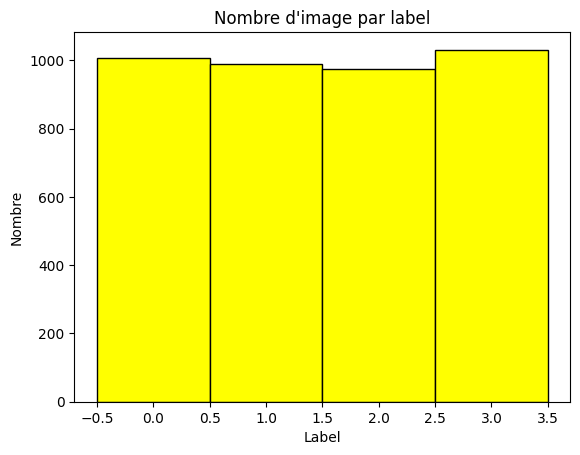

In [21]:
afficher_repartition(data_train_sans_transform)

Entraînement du modèle Wed Jun 28 22:27:02 2023
[42/51]


100%|██████████| 400/400 [00:09<00:00, 40.89it/s]


accuracy : 98.88888888888889 %, loss : 0.758644700050354  val accuracy : 100.0 %, val_loss : 0.7479618787765503

[43/51]


100%|██████████| 400/400 [00:10<00:00, 39.12it/s]


accuracy : 98.91666666666667 %, loss : 0.7585105895996094  val accuracy : 100.0 %, val_loss : 0.7479714155197144

[44/51]


100%|██████████| 400/400 [00:09<00:00, 41.51it/s]


accuracy : 98.91666666666667 %, loss : 0.7584084868431091  val accuracy : 100.0 %, val_loss : 0.7479915618896484

[45/51]


100%|██████████| 400/400 [00:10<00:00, 38.57it/s]


accuracy : 98.91666666666667 %, loss : 0.7583171129226685  val accuracy : 100.0 %, val_loss : 0.748015284538269

[46/51]


100%|██████████| 400/400 [00:10<00:00, 39.07it/s]


accuracy : 98.91666666666667 %, loss : 0.7582318782806396  val accuracy : 100.0 %, val_loss : 0.7480401992797852

[47/51]


100%|██████████| 400/400 [00:09<00:00, 43.49it/s]


accuracy : 98.94444444444444 %, loss : 0.7581506371498108  val accuracy : 100.0 %, val_loss : 0.7480656504631042

[48/51]


100%|██████████| 400/400 [00:08<00:00, 44.77it/s]


accuracy : 98.94444444444444 %, loss : 0.758072555065155  val accuracy : 100.0 %, val_loss : 0.7480913400650024

[49/51]


100%|██████████| 400/400 [00:08<00:00, 44.50it/s]


accuracy : 98.97222222222223 %, loss : 0.7579969763755798  val accuracy : 100.0 %, val_loss : 0.7481171488761902

[50/51]


100%|██████████| 400/400 [00:09<00:00, 42.82it/s]


accuracy : 99.02777777777777 %, loss : 0.757923424243927  val accuracy : 100.0 %, val_loss : 0.7481430172920227

[51/51]


100%|██████████| 400/400 [00:14<00:00, 28.05it/s]


accuracy : 99.05555555555556 %, loss : 0.7578515410423279  val accuracy : 100.0 %, val_loss : 0.7481687664985657

Fin entraînement du modèle en 584.7024917602539 s
Training loss : [0.758644700050354, 0.7585105895996094, 0.7584084868431091, 0.7583171129226685, 0.7582318782806396, 0.7581506371498108, 0.758072555065155, 0.7579969763755798, 0.757923424243927, 0.7578515410423279]
Training accuracy : [98.88888888888889, 98.91666666666667, 98.91666666666667, 98.91666666666667, 98.91666666666667, 98.94444444444444, 98.94444444444444, 98.97222222222223, 99.02777777777777, 99.05555555555556]
Validation loss : [0.7479618787765503, 0.7479714155197144, 0.7479915618896484, 0.748015284538269, 0.7480401992797852, 0.7480656504631042, 0.7480913400650024, 0.7481171488761902, 0.7481430172920227, 0.7481687664985657]
Validation accuracy : [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]



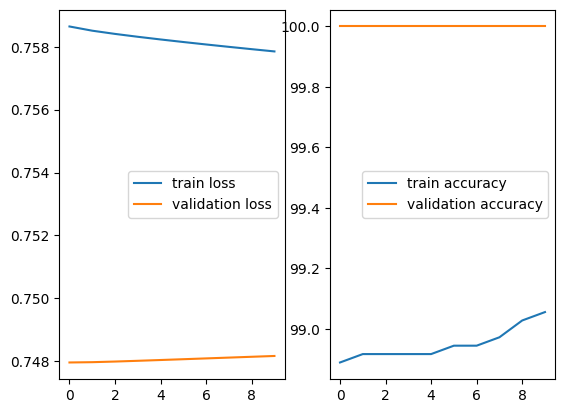

In [22]:
model = AlexNet()
model = ResNet()
model = LeNet()
model = ResNetTL()
model = DenseNetTL()
if DERNIER_MODELE >= 0 :
    with open(f"model/model{DERNIER_MODELE}.pkl", "rb") as f :
        model = pickle.load(f)

model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

result_train_loss, result_train_predictions, result_val_loss, result_val_predictions = entrainer_modele(model, optimizer, data_train_sans_transform)
print("Training loss :", result_train_loss)
print("Training accuracy :", result_train_predictions)
print("Validation loss :", result_val_loss)
print("Validation accuracy :", result_val_predictions)
print()
fig, axes = plt.subplots(1, 2)
axes[0].plot(result_train_loss, label="train loss")
axes[0].plot(result_val_loss, label="validation loss")
axes[0].legend()

axes[1].plot(result_train_predictions, label="train accuracy")
axes[1].plot(result_val_predictions, label="validation accuracy")
axes[1].legend()
plt.show()

# PREDICTION SUR LA BASE DE TEST

In [23]:
def positions_valeurs_minimales(liste, nombre=5, reverse=False):
    positions = sorted(enumerate(liste), key=lambda x: x[1], reverse=reverse)[:nombre]
    return [pos for pos, _ in positions]

def majority_vote(row):
    counts = row.value_counts()
    majority_class = counts.index[0]
    return majority_class

In [24]:
def test_modele(model, data_test:list, data_train=None, loss=torch.nn.CrossEntropyLoss()) :
    model.eval()
    with torch.no_grad() :
        if not (data_train is None) :
            print("Vérification du modèle sur les données d'entraînement")
            data_dict_val = data_train[["image", "label"]].to_dict("records")
            X_load_val= torch.utils.data.DataLoader(data_dict_val, batch_size=1, num_workers=1)
            val_loss, val_predictions = validation(model, X_load_val, loss)
            print("val accuracy :", val_predictions, "%, val_loss :", val_loss)
        
        print("Application du modèle sur le jeu de test")
        t0 = time.time()
        predictions = []
        X_load = torch.utils.data.DataLoader(data_test, batch_size=1, num_workers=1)
        for _, data in enumerate(tqdm(X_load)) :
            X_data = data["image"].to(device)
            sortie = model(X_data)
            predictions.append(torch.argmax(sortie).item())
    print("Fin prédictions en ", time.time()-t0, "s")
    return predictions

In [25]:
model_tests_best_val_loss = positions_valeurs_minimales(result_val_loss, 5)
print("Modèle avec la meilleure val_loss :", model_tests_best_val_loss)
model_tests_best_val_accuracy = positions_valeurs_minimales(result_val_predictions, 5, True)
print("Modèle avec la meilleure val_accuracy :", model_tests_best_val_accuracy)

Modèle avec la meilleure val_loss : [0, 1, 2, 3, 4]
Modèle avec la meilleure val_accuracy : [0, 1, 2, 3, 4]


In [26]:
resultats_voting = pd.DataFrame()
resultats_voting["id"] = np.arange(4000, 5082)
model_tests = np.unique(model_tests_best_val_loss + model_tests_best_val_accuracy)
# model_tests = np.array(model_tests_best_val_loss)
model_tests = range(41, 50)
vote_cols = []
for num_model_test in model_tests :
    with open(f"model/model{num_model_test}.pkl", "rb") as f :
        model_test = pickle.load(f)
    res = test_modele(model_test, data_test)
    nom_col = "label" + str(num_model_test)
    vote_cols.append(nom_col)
    resultats_voting[nom_col] = res    
    print()

resultats_voting["label"] = resultats_voting[vote_cols].apply(majority_vote, axis=1)
resultats = resultats_voting[["id", "label"]].copy()
resultats["label"] = resultats["label"] + 1
resultats.to_csv("resultats.csv", sep=",", index=False)
resultats_voting.to_csv("all_resultats.csv", sep=",", index=False)

Application du modèle sur le jeu de test


100%|██████████| 1082/1082 [00:23<00:00, 45.91it/s]


Fin prédictions en  23.56952691078186 s

Application du modèle sur le jeu de test


100%|██████████| 1082/1082 [00:23<00:00, 45.79it/s]


Fin prédictions en  23.63248920440674 s

Application du modèle sur le jeu de test


100%|██████████| 1082/1082 [00:23<00:00, 46.24it/s]


Fin prédictions en  23.402094841003418 s

Application du modèle sur le jeu de test


100%|██████████| 1082/1082 [00:23<00:00, 46.04it/s]


Fin prédictions en  23.503487825393677 s

Application du modèle sur le jeu de test


100%|██████████| 1082/1082 [00:23<00:00, 46.27it/s]


Fin prédictions en  23.384922742843628 s

Application du modèle sur le jeu de test


100%|██████████| 1082/1082 [00:29<00:00, 36.37it/s]


Fin prédictions en  29.755046844482422 s

Application du modèle sur le jeu de test


100%|██████████| 1082/1082 [00:23<00:00, 45.72it/s]


Fin prédictions en  23.673464059829712 s

Application du modèle sur le jeu de test


100%|██████████| 1082/1082 [00:26<00:00, 41.33it/s]


Fin prédictions en  26.18705129623413 s

Application du modèle sur le jeu de test


100%|██████████| 1082/1082 [00:23<00:00, 45.80it/s]


Fin prédictions en  23.629151582717896 s



affichage répartition par classe
{0: 251, 1: 279, 2: 284, 3: 268}


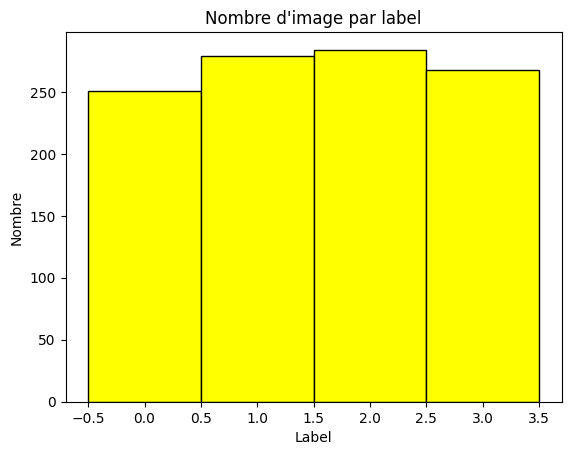

In [27]:
afficher_repartition(resultats_voting)